In [1]:

# LSTM model dummy
# Dummy model to predict the climate time series data

# !nvidia-smi

import tensorflow as tf 
# !pip install tensorflow-gpu
print(tf.__version__)

print('1: ', tf.config.list_physical_devices('GPU'))
print('2: ', tf.test.is_built_with_cuda)
print('3: ', tf.test.gpu_device_name())
print('4: ', tf.config.get_visible_devices())

2.6.2
1:  []
2:  <function is_built_with_cuda at 0x7f654adec048>
3:  
4:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [1]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import pandas as pd
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout, Bidirectional, RepeatVector, TimeDistributed
import math
from sklearn.metrics import mean_squared_error

## Data Processing

### Data Fetching and Cleaning

In [3]:


# create a dataset of 30 sequences from the provided Data
def creatDataset(x,y,time_step):
    Xs, Ys = [],[]
    for i in range(len(x)-time_step):
        v = x.iloc[i:i+time_step].values
        Xs.append(v)
        Ys.append(x.iloc[i+time_step])
    return np.array(Xs),np.array(Ys)
    

In [4]:
#getting data and sorting it into all the present IDs

scaler = MinMaxScaler()
df_normal = pd.read_csv('train_1.csv', delimiter=',')
df_normal = df_normal.dropna(axis=1, how='all')
all_IDs = np.array(df_normal.groupby(['ID']).count().index.values)
print(len(all_IDs))
df_ID_list = list()
for i in all_IDs:
    temp = df_normal[df_normal['ID']==i].dropna(axis=1, how='all')
    temp = temp.drop(temp[['Label']],axis =1)
    df_ID_list.append(temp)

# print(df_ID_list)

for i in df_ID_list:
    print(i.head())

# df_normal_grp_ID1 = df_normal[df_normal['ID']=='id1'].dropna(axis=1, how='all')
# df_normal_grp_ID1 = df_normal_grp_ID1.drop(df_normal_grp_ID1[['Label','ID']],axis =1)
# # df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:(int(len(df_normal_grp_ID1)/5)),:]
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[200000:600000,:]
# df_normal_grp_ID1[['Time']] = scaler.fit_transform(df_normal_grp_ID1[['Time']])
# # df_normal_grp_ID1
# plt.plot(df_normal_grp_ID1['Signal1'])

10
           Time   ID  Signal1  Signal2
5   2100.475551  id1      0.0     0.00
12  2115.475551  id1      0.0     0.25
20  2130.475551  id1      0.0     0.50
27  2145.475551  id1      0.0     0.75
33  2160.475551  id1      0.0     1.00
            Time    ID   Signal1   Signal2   Signal3   Signal4
14   2119.052781  id10  0.454548  0.111111  0.947794  0.170395
36   2164.052781  id10  0.458264  0.222222  0.944957  0.173531
57   2209.052781  id10  0.463317  0.444444  0.942139  0.177798
79   2254.052781  id10  0.465843  0.555556  0.939291  0.179931
100  2299.052781  id10  0.461979  0.777778  0.936495  0.176668
           Time   ID  Signal1  Signal2   Signal3
7   2103.512006  id2      0.0      0.0  0.241885
22  2133.512006  id2      0.0      0.0  0.242558
35  2163.512006  id2      0.0      0.0  0.243231
50  2193.512006  id2      0.0      0.0  0.243736
65  2223.512006  id2      0.0      0.0  0.244240
           Time   ID  Signal1  Signal2
2   2090.885618  id3      0.2      1.0
10  2105.8856

Text(0.5, 1.0, 'Plateau Attack (180000-190000) values')

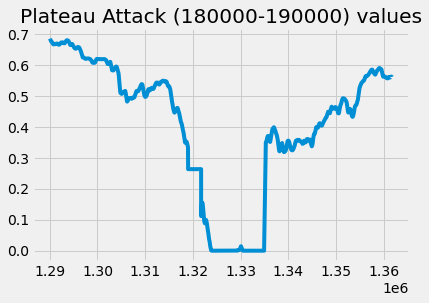

In [15]:
df_test_plat_ID1 = pd.read_csv('test_plateau.csv', delimiter=',')
df_test_plat_ID1 = df_test_plat_ID1[df_test_plat_ID1['ID']=='id1'].dropna(axis=1, how='all')
df_test_plat_ID1 = df_test_plat_ID1.drop(df_test_plat_ID1[['Label','ID']],axis =1)
# df_test_plat_ID1 = df_test_plat_ID1.iloc[0:(int(len(df_test_plat_ID1)/5)),:]
# df_test_plat_ID1 = df_test_plat_ID1.iloc[180000:200000,:]
df_test_plat_ID1[['Time']] = scaler.fit_transform(df_test_plat_ID1[['Time']])

# df_test_plat_ID1.iloc[180000:250000,0:2]

plt.plot(df_test_plat_ID1.iloc[180000:190000,1:2])
plt.title('Plateau Attack (180000-190000) values')

In [16]:
TIME_STEP = 30
X_train, Y_train = creatDataset(df_normal_grp_ID1[['Signal1']], df_normal_grp_ID1[['Signal1']], TIME_STEP)
X_test, Y_test = creatDataset(df_test_plat_ID1[['Signal1_of_ID']], df_test_plat_ID1[['Signal1_of_ID']], TIME_STEP)

X_train.shape

X_test.shape

(299967, 30, 1)

### LSTM AUTOENCODER
#### Model Desgin

In [12]:


# n_features = X_train.shape[2]
model= Sequential()
model.add(
    TimeDistributed(
        LSTM(128, activation='relu', return_sequences = True), 
        input_shape=(4,30,1) #all IDs LSTMs 
    )
)

model.add(
    TimeDistributed(
        Flatten() 
    )
)
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(TimeDistributed(Dense(30)))
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_20 (TimeDis (None, 4, 30, 128)        66560     
_________________________________________________________________
time_distributed_21 (TimeDis (None, 4, 3840)           0         
_________________________________________________________________
dense_19 (Dense)             (None, 4, 512)            1966592   
_________________________________________________________________
dense_20 (Dense)             (None, 4, 256)            131328    
_________________________________________________________________
time_distributed_22 (TimeDis (None, 4, 30)             7710      
Total params: 2,172,190
Trainable params: 2,172,190
Non-trainable params: 0
_________________________________________________________________


#### Model Fitting

In [36]:
# fit model
model.fit(X_train, Y_train, epochs=15, batch_size=30, validation_split=0.1, shuffle=False)
model.save("single_ID_LSTM_autoenc")

Epoch 1/15
12000/12000 [==============================] - 297s 25ms/step - loss: 0.0123 - val_loss: 0.2490
Epoch 2/15
12000/12000 [==============================] - 296s 25ms/step - loss: 0.0104 - val_loss: 0.2359
Epoch 3/15
12000/12000 [==============================] - 296s 25ms/step - loss: 0.0109 - val_loss: 0.2246
Epoch 4/15
12000/12000 [==============================] - 295s 25ms/step - loss: 0.0117 - val_loss: 0.2242
Epoch 5/15
12000/12000 [==============================] - 295s 25ms/step - loss: 0.0119 - val_loss: 0.2307
Epoch 6/15
12000/12000 [==============================] - 296s 25ms/step - loss: 0.0125 - val_loss: 0.2297
Epoch 7/15
12000/12000 [==============================] - 295s 25ms/step - loss: 0.0130 - val_loss: 0.2162
Epoch 8/15
12000/12000 [==============================] - 295s 25ms/step - loss: 0.0135 - val_loss: 0.2206
Epoch 9/15
12000/12000 [==============================] - 295s 25ms/step - loss: 0.0136 - val_loss: 0.2199
Epoch 10/15
12000/12000 [============

#### Training loss, finding Threshold

/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


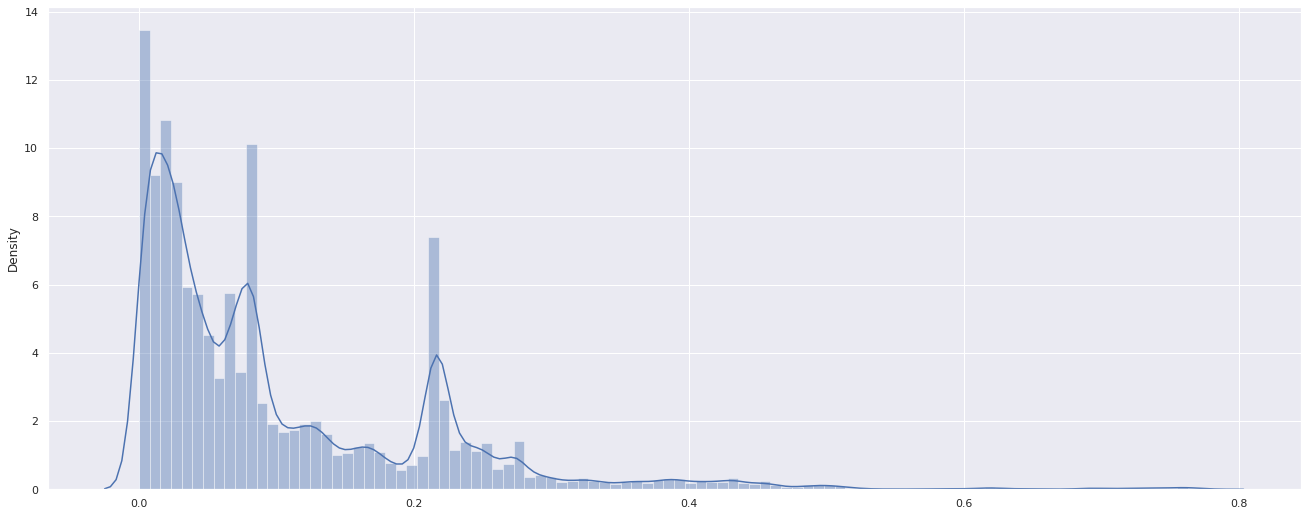

In [20]:
reconstructed_model = keras.models.load_model("single_ID_LSTM_autoenc")
x_train_predict = reconstructed_model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(x_train_predict - X_train), axis=1)
sns.set(rc={'figure.figsize':(20,8.27)})
sns.distplot(train_mae_loss,bins=100,kde=True)
plt.savefig('training_loss.png')


### Test Loss

(299967, 1)


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

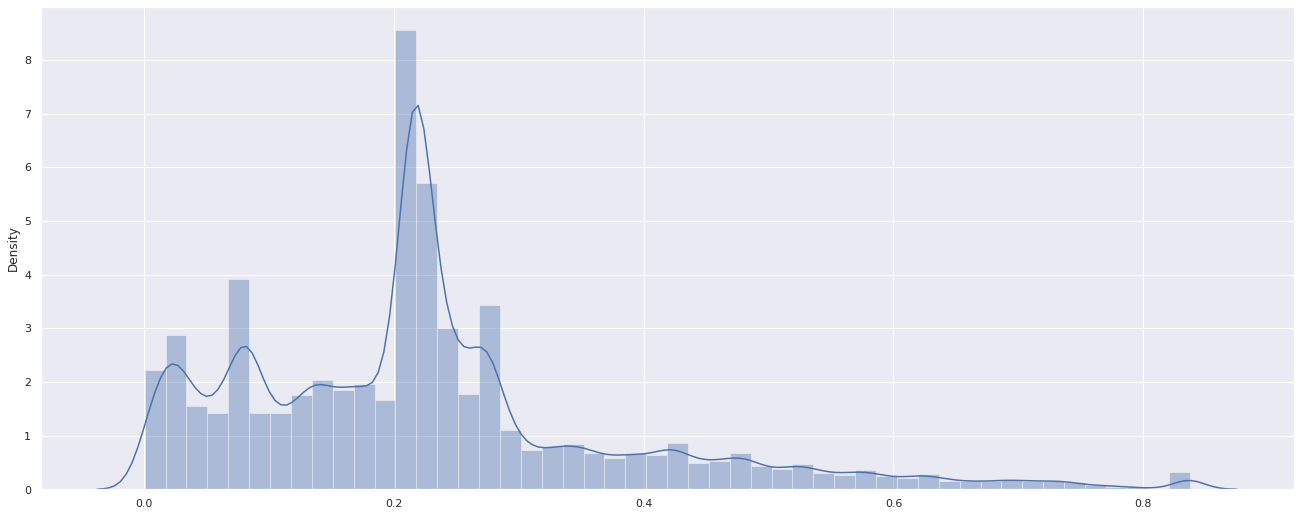

In [21]:
THRESHOLD = 0.45

x_test_predict = reconstructed_model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(x_test_predict - X_test), axis=1)
print(test_mae_loss.shape)

sns.distplot(test_mae_loss,bins=50,kde=True )

### Test Score Dataframe Creation and plotting


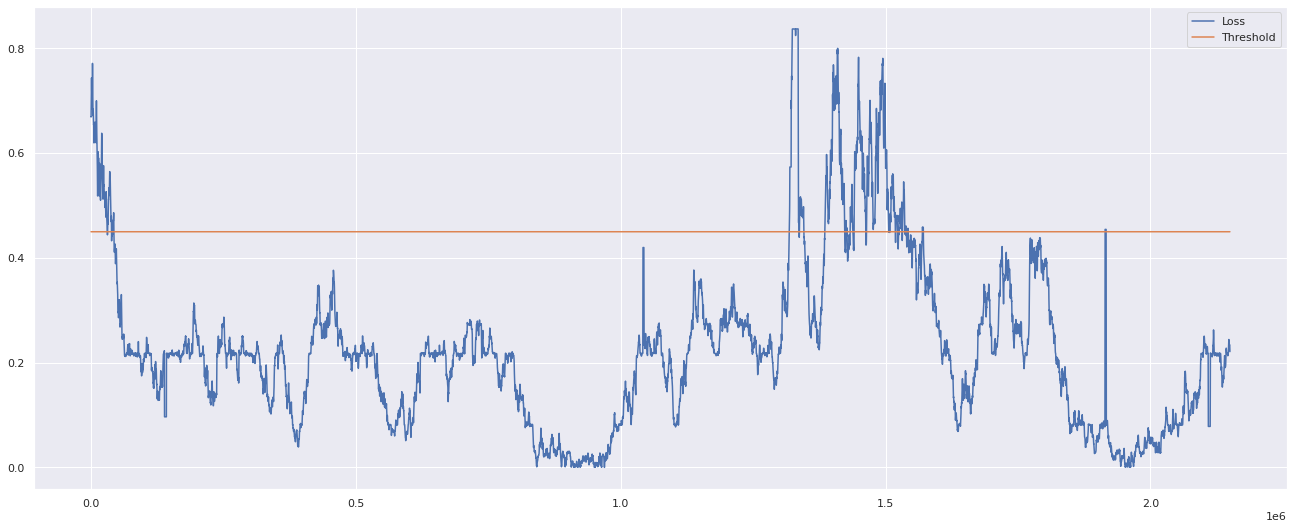

In [22]:
test_score_df = pd.DataFrame(index=df_test_plat_ID1[TIME_STEP:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Signal1'] = df_test_plat_ID1[TIME_STEP:].Signal1_of_ID

#plot the threshoold vs the actual loss values
plt.plot(test_score_df.index, test_score_df.loss, label='Loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='Threshold')
plt.legend()


# df['meantemp'].plot()
# df['humidity'].plot()
# plt.legend(['Sig1','Sig2'])

# train_set=df[:'2016'].iloc[:,0]
# test_set=df['2016':].iloc[:,0]
# df_normal_grp_ID1['Signal1_of_ID'].head()
# plt.plot(df_normal_grp_ID1['Time'],df_normal_grp_ID1['Signal1_of_ID'])
# df_normal_grp_ID1 = df_normal_grp_ID1.iloc[0:500,:]
# fig = 
# len(df_normal_grp_ID1)
# df_normal_grp_ID1['Signal1'].plot()

In [23]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,loss,threshold,anomaly,Signal1
215,0.669239,0.45,True,0.167412
221,0.669160,0.45,True,0.167262
230,0.669098,0.45,True,0.167152
236,0.669054,0.45,True,0.167022
243,0.669030,0.45,True,0.166892


/fibus/fs3/04/cde1001/.local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


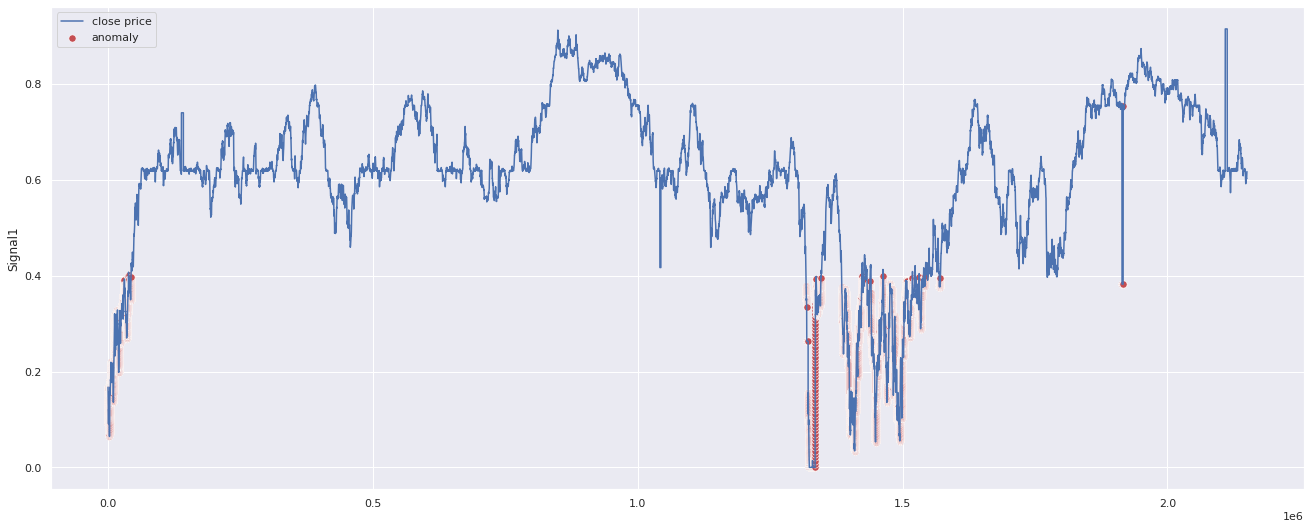

In [18]:
plt.plot(
  df_test_plat_ID1[TIME_STEP:].index, 
  df_test_plat_ID1[TIME_STEP:].Signal1_of_ID, 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  anomalies.Signal1,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.legend();